In [1]:
import os
from typing import Optional
from datetime import datetime

import pandas as pd
import geopandas as gpd

import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML

# %matplotlib widget
# %matplotlib inline

#### This was the testing ground for developing the `animate_bikeshare_system.py` script. Please refer to this script for useful application of the code in this notebook.

In [2]:
bikeshare_gdf = gpd.read_file("../processed_gbfs_data/bikeshare_2025-02-28_15-44-09.geojson")

In [ ]:
SEATTLE_GEOJSON_URL = "https://raw.githubusercontent.com/seattleflu/seattle-geojson/master/seattle_geojsons/2016_seattle_city.geojson"
NEIGHBORHOOD_BOUNDARIES_URL = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/refs/heads/master/data/neighborhoods.geojson"


def load_seattle_boundary(url: str) -> gpd.GeoDataFrame:
    """load seattle boundary as a geopandas dataframe"""
    seattle_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_gdf.to_crs("EPSG:32610", inplace=True)

    return seattle_gdf


def load_neighborhoods(url: str, seattle_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Load Seattle neighborhoods geopandas dataframe"""
    seattle_neighborhoods_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_neighborhoods_gdf.to_crs("EPSG:32610", inplace=True)

    seattle_neighborhoods_gdf = seattle_neighborhoods_gdf.clip(seattle_gdf)
    
    return seattle_neighborhoods_gdf


def dissolve_neighborhoods(seattle_neighborhoods_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Group nested neighborhoods into single nieghborhood polygons"""
    return seattle_neighborhoods_gdf[["nhood", "area", "geometry"]].dissolve(by="nhood", aggfunc="sum")


def filter_bikeshare_system_by_nhood(
    bikeshare_gdf: gpd.GeoDataFrame,
    nhood_gdf: gpd.GeoDataFrame,
    neighborhood: Optional[str] = None
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """This thing"""
    if neighborhood:
        if neighborhood not in nhood_gdf.index:
            raise ValueError(f"Neighborhood '{neighborhood}' not found in Seattle. Must be one of {nhood_gdf.index}.")
        else:
            nhood_sub_gdf = nhood_gdf[nhood_gdf.index == neighborhood]
    else:
        nhood_sub_gdf = nhood_gdf

    return bikeshare_gdf.clip(nhood_sub_gdf), nhood_sub_gdf


def filter_bikeshare_system_by_start_date(gdf: gpd.GeoDataFrame, start_date: datetime, num_days: int) -> gpd.GeoDataFrame:
    """Filter bikshare system by date"""
    end_time = start_date + pd.Timedelta(days=num_days)
    mask = (gdf.datetime >= start_date) & (gdf.datetime < end_time)

    return gdf.loc[mask]


def animate_bikeshare_system_evolution(
    gdf: gpd.GeoDataFrame,
    nhoods_gdf: gpd.GeoDataFrame,
    neighborhood: Optional[str] = None
) -> animation.FuncAnimation:
    # Set up figure and 3D axes
    animation.writer = animation.writers['ffmpeg']

    plt.ioff()
    fig = plt.figure(figsize=(8, 8), dpi=120)
    ax = fig.add_subplot(111)

    times = gdf.datetime.sort_values().unique()

    if neighborhood:
        markersize = 30
        linewidth = 5
        alpha = 1

    else:
        neighborhood = "Seattle"
        markersize = 10
        linewidth = 1
        alpha = 0.5

    # write the update function, specifically including the ax.clear() function this was important.
    def update(i):
        ax.clear()
        # iterate over time
        nhoods_gdf.plot(ax=ax, facecolor="None", edgecolor='black', linewidth=linewidth)
        gdf[gdf.datetime == times[i]].plot(ax=ax, column="vehicle_type", markersize=markersize, legend=True, alpha=alpha)
        ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.CartoDB.VoyagerNoLabels, attribution=False)
        ax.set_title(f"State of Bikeshare System in {neighborhood}\n{times[i].strftime('%Y-%m-%d %H:%M:%S')}")
        ax.axis("off")

        return ax

    # frames=len(time)
    ani = animation.FuncAnimation(fig, update, frames=range(len(times)), interval=75)

    visuals_dir = "visuals/"
    if not os.path.exists(visuals_dir):
        os.makedirs(visuals_dir)

    start_date = times[0].strftime('%Y-%m-%d')
    end_date = times[-1].strftime('%Y-%m-%d')
    animation_filename = f"bike_share_system_evolution_{neighborhood}_{start_date}_{end_date}"
    filepath = os.path.join(visuals_dir, animation_filename)

    ani.save(f"{filepath}.gif", writer='pillow')
    writer = animation.writers['ffmpeg']
    writer = writer(metadata=dict(artist='Hunter Lybbert'), fps=10)
    ani.save(f"{filepath}.mp4", writer=writer)
    
    return ani


def run(
    bikeshare_gdf: gpd.GeoDataFrame,
    date: str,
    num_days: int,
    neighborhood: Optional[str] = None
) -> gpd.GeoDataFrame:
    seattle_gdf = load_seattle_boundary(url=SEATTLE_GEOJSON_URL)
    seattle_neighborhoods_gdf = load_neighborhoods(url=NEIGHBORHOOD_BOUNDARIES_URL, seattle_gdf=seattle_gdf)
    seattle_neighborhoods_gdf = dissolve_neighborhoods(seattle_neighborhoods_gdf)
    bikeshare_sub_gdf = filter_bikeshare_system_by_start_date(
        gdf=bikeshare_gdf, start_date=datetime.strptime(date, "%Y-%m-%d"), num_days=num_days
    )
    bikeshare_sub_gdf, nhood_sub_gdf = filter_bikeshare_system_by_nhood(
        bikeshare_gdf=bikeshare_sub_gdf,
        nhood_gdf=seattle_neighborhoods_gdf,
        neighborhood=neighborhood,
    )
    return animate_bikeshare_system_evolution(bikeshare_sub_gdf, nhood_sub_gdf, neighborhood=neighborhood)

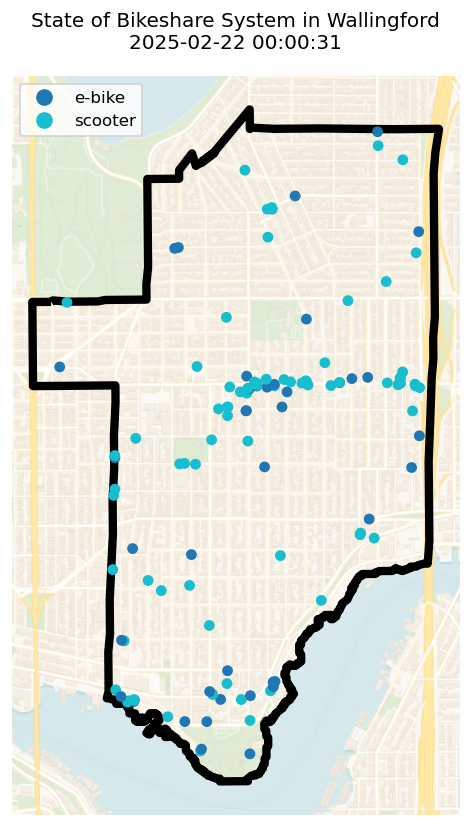

In [5]:
ani = run(bikeshare_gdf, date="2025-02-22", num_days=1, neighborhood="Wallingford")

In [13]:
ani = run(bikeshare_gdf, date="2025-02-22", num_days=1, neighborhood="Ballard")

In [14]:
ani = run(bikeshare_gdf, date="2025-02-22", num_days=1, neighborhood="Capitol Hill")

In [15]:
ani = run(bikeshare_gdf, date="2025-02-22", num_days=1)